# Test 4 : compare Logistic Regression, GCN, and GAT classifier

## Table of contents

1. [Logistic Regression](#1-logistic-regression)
2. [GCN classifier](#2-gcn)
3. [GAT classifier](#3-gat)
4. [Evaluate performances](#4-performances)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from evaluation.ClassificationMetrics import ClassificationMetrics

from manage.GCNClassifierTrainTestManager import GCNClassifierTrainTestManager
from manage.LogisticRegressionTrainTestManager import LogisticRegressionTrainTestManager
from manage.GATClassifierTrainTestManager import GATClassifierTrainTestManager

from models.GCNClassifier import GCNClassifier
from models.LogisticRegression import LogisticRegression
from models.GATClassifier import GATClassifier

from sklearn.preprocessing import StandardScaler

from utils.preProcessing import preProcessing

## 0. Reading and preprocessing

In [2]:
# Reading
df = pd.read_excel('data/table-s1-sigmut-indel.xlsx')

# Drop non naive patients
df = df.loc[df["Cohort"] == "Naive"]

# Drop NaN values
df = preProcessing.delete_nan_values(df)

# Relabel patients
t = 183
df = preProcessing.relabel_patients(df, "Progression_1","Time to progression (days)",t)

# Select features
features_name = ["Age at advanced disease diagnosis","CD8+ T cell score","Genome mut per mb","Exome mut per mb","CD274 expression","M1M2 expression","SBS1","SBS2","SBS3","SBS4","SBS5","SBS7a","SBS7b","SBS7c","SBS7d","SBS8","SBS10a","SBS10b","SBS10c","SBS13","SBS15","SBS17a","SBS17b","SBS18","SBS31","SBS35","SBS36","SBS37","SBS38","SBS40","SBS44","SBS4426","ID1","ID2","ID3","ID4","ID5","ID6","ID7","ID8","ID9","ID10","ID11","ID12","ID13","ID14","ID15","ID16","ID17","ID18"]
features_to_normalize = ["Age at advanced disease diagnosis","CD8+ T cell score","Genome mut per mb","Exome mut per mb","CD274 expression","M1M2 expression"]

# Normalize features except mutational signatures
df.loc[:,features_to_normalize] = StandardScaler().fit_transform(df.loc[:,features_to_normalize].to_numpy())

# Extract features
X = df.loc[:,features_name].to_numpy()

# Numerize label
y = df["Progression_1"].to_numpy()

## 1. Logistic Regression

In [3]:
# Instanciate logistic regression classifier with its train test manager
log_reg_clf = LogisticRegression(len(features_name))
log_reg_manager = LogisticRegressionTrainTestManager(log_reg_clf)

In [4]:
# Make the leave one out cross validation
n_epochs = 50
scores_log_reg, classes_log_reg, train_loss_log_reg, val_loss_log_reg, std_train_loss_log_reg, std_val_loss_log_reg, params_fc_log_reg = log_reg_manager.leave_one_out_cross_validation(X, y, n_epochs)

## 2. GCN classifier

In [5]:
# Build group (all in same group)
group = df["Tumour type"].to_numpy()

In [6]:
# Instanciate GCN classifier with its train test manager
gcn_clf = GCNClassifier(len(features_name))
gcn_manager = GCNClassifierTrainTestManager(gcn_clf)

In [7]:
# Make the leave one out cross validation
scores_gcn, classes_gcn, train_loss_gcn, val_loss_gcn, std_train_loss_gcn, std_val_loss_gcn, params_conv_gcn, params_fc_gcn = gcn_manager.leave_one_out_cross_validation(X, y, group, n_epochs, "euclidean",3)

## 3. GAT classifier

In [8]:
# Instanciate GCN classifier with its train test manager
gat_clf = GATClassifier(len(features_name))
gat_manager = GATClassifierTrainTestManager(gat_clf)

In [11]:
# Make the leave one out cross validation
scores_gat, classes_gat, train_loss_gat, val_loss_gat, std_train_loss_gat, std_val_loss_gat, params_attention_gat, params_conv_gat, params_fc_gat = gat_manager.leave_one_out_cross_validation(X, y, group, n_epochs)

## 4. Evaluate performances

In [12]:
# Logistic Regression
fpr_log_reg, tpr_log_reg, thresholds_log_reg = ClassificationMetrics.compute_roc_curve(y, scores_log_reg)
sensitivity_log_reg, specificity_log_reg = ClassificationMetrics.compute_sensitivity_specificity(y, classes_log_reg)

# GCN
fpr_gcn, tpr_gcn, thresholds_gcn = ClassificationMetrics.compute_roc_curve(y, scores_gcn)
sensitivity_gcn, specificity_gcn = ClassificationMetrics.compute_sensitivity_specificity(y, classes_gcn)

# GAT
fpr_gat, tpr_gat, thresholds_gat = ClassificationMetrics.compute_roc_curve(y, scores_gat)
sensitivity_gat, specificity_gat = ClassificationMetrics.compute_sensitivity_specificity(y, classes_gat)

In [13]:
# Logistic Regression
features_importance_log_reg = np.absolute(np.mean([params_fc_log_reg[i].detach().numpy() for i in range(len(params_fc_log_reg))],axis=0))[0]
index_sort = np.argsort(features_importance_log_reg)
features_importance_sorted_log_reg = features_importance_log_reg[index_sort]
features_name_sorted_log_reg = np.array(features_name)[index_sort]

# GCN
features_importance_gcn = np.absolute(np.mean([np.mean(params_conv_gcn[i].detach().numpy(),axis=1) for i in range(len(params_conv_gcn))],axis=0))
index_sort = np.argsort(features_importance_gcn)
features_importance_sorted_gcn = features_importance_gcn[index_sort]
features_name_sorted_gcn = np.array(features_name)[index_sort]

# GAT
features_importance_gat = np.absolute(np.mean([np.mean(params_attention_gat[i].detach().numpy(),axis=1) for i in range(len(params_attention_gat))],axis=0))
index_sort = np.argsort(features_importance_gat)
features_importance_sorted_gat = features_importance_gat[index_sort]
features_name_sorted_gat = np.array(features_name)[index_sort]

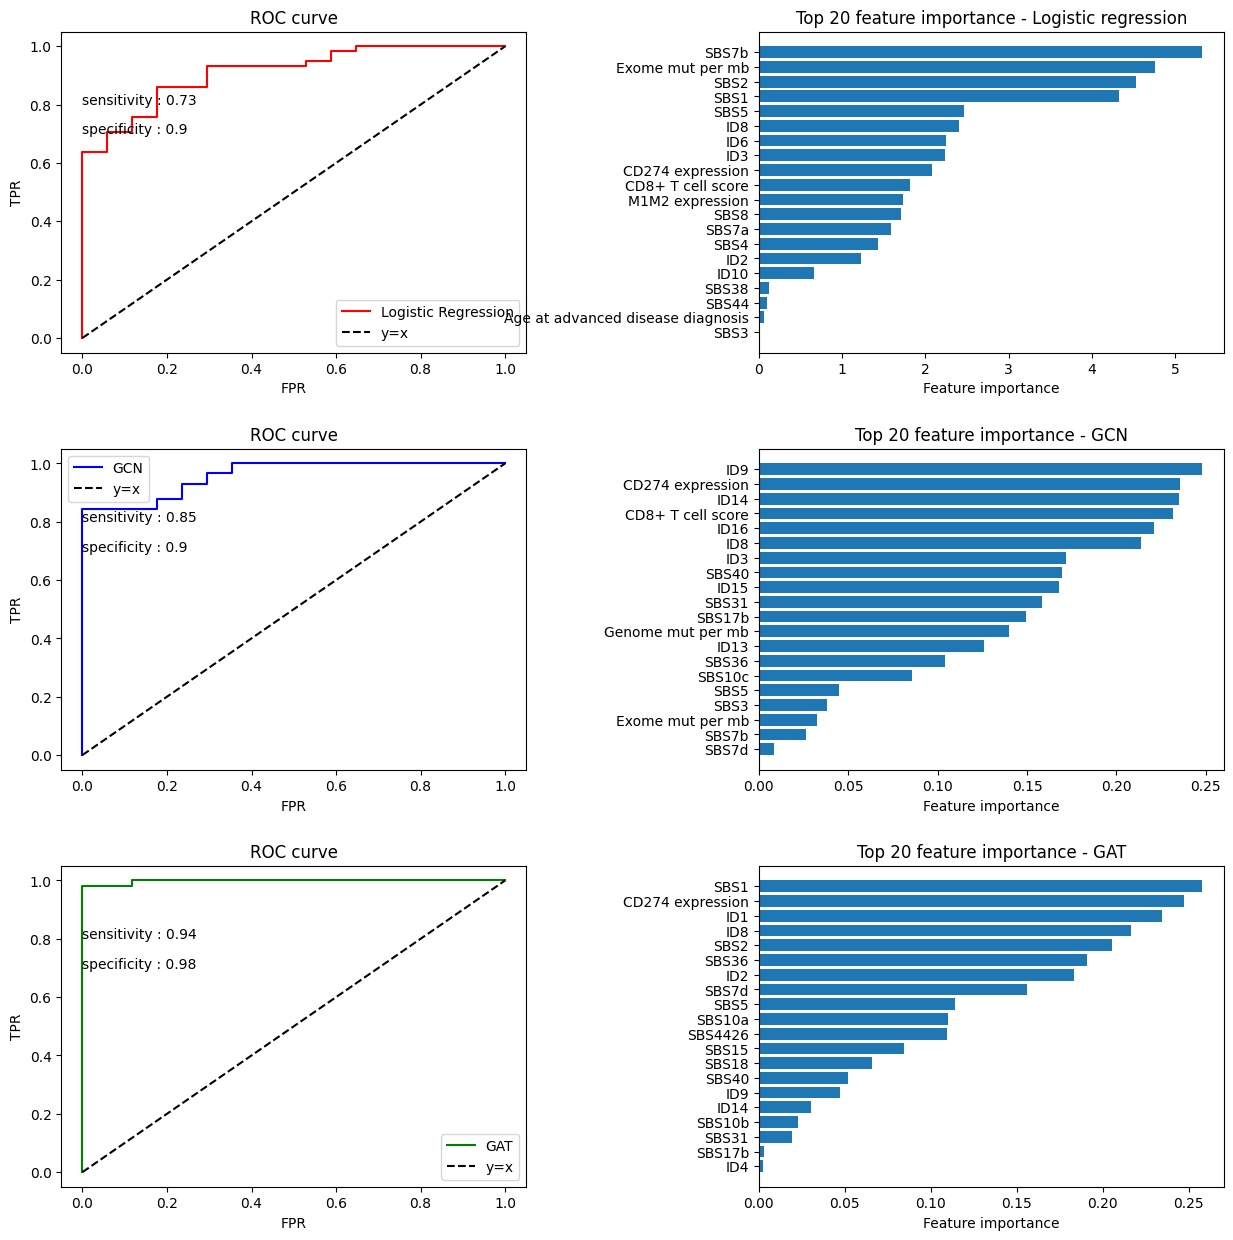

In [17]:
fig, ax = plt.subplots(3,2,figsize=(15,15))
x = np.linspace(0,1,100)

# Logistic Regression
# ROC curve
ax[0,0].plot(fpr_log_reg, tpr_log_reg, color='red',label='Logistic Regression')
ax[0,0].plot(x,x,linestyle='--',color='black',label='y=x')
ax[0,0].set_xlabel('FPR')
ax[0,0].set_ylabel('TPR')
ax[0,0].set_title('ROC curve')
ax[0,0].text(0,0.8,f"sensitivity : {sensitivity_log_reg}")
ax[0,0].text(0,0.7,f"specificity : {specificity_log_reg}")
ax[0,0].legend()

# Feature importance
ax[0,1].barh(features_name_sorted_log_reg[:20],features_importance_sorted_log_reg[:20])
ax[0,1].set_xlabel("Feature importance")
ax[0,1].set_title("Top 20 feature importance - Logistic regression")

# GCN
# ROC curve
ax[1,0].plot(fpr_gcn, tpr_gcn, color='blue',label='GCN')
ax[1,0].plot(x,x,linestyle='--',color='black',label='y=x')
ax[1,0].set_xlabel('FPR')
ax[1,0].set_ylabel('TPR')
ax[1,0].set_title('ROC curve')
ax[1,0].text(0,0.8,f"sensitivity : {sensitivity_gcn}")
ax[1,0].text(0,0.7,f"specificity : {specificity_gcn}")
ax[1,0].legend()

# Feature importance
ax[1,1].barh(features_name_sorted_gcn[0:20],features_importance_sorted_gcn[0:20])
ax[1,1].set_xlabel("Feature importance")
ax[1,1].set_title("Top 20 feature importance - GCN")

# GAT
# ROC curve
ax[2,0].plot(fpr_gat, tpr_gat, color='green',label='GAT')
ax[2,0].plot(x,x,linestyle='--',color='black',label='y=x')
ax[2,0].set_xlabel('FPR')
ax[2,0].set_ylabel('TPR')
ax[2,0].set_title('ROC curve')
ax[2,0].text(0,0.8,f"sensitivity : {sensitivity_gat}")
ax[2,0].text(0,0.7,f"specificity : {specificity_gat}")
ax[2,0].legend()

# Feature importance
ax[2,1].barh(features_name_sorted_gat[0:20],features_importance_sorted_gat[0:20])
ax[2,1].set_xlabel("Feature importance")
ax[2,1].set_title("Top 20 feature importance - GAT")

plt.subplots_adjust(hspace=0.3, wspace=0.5)

### Train loss and validation loss

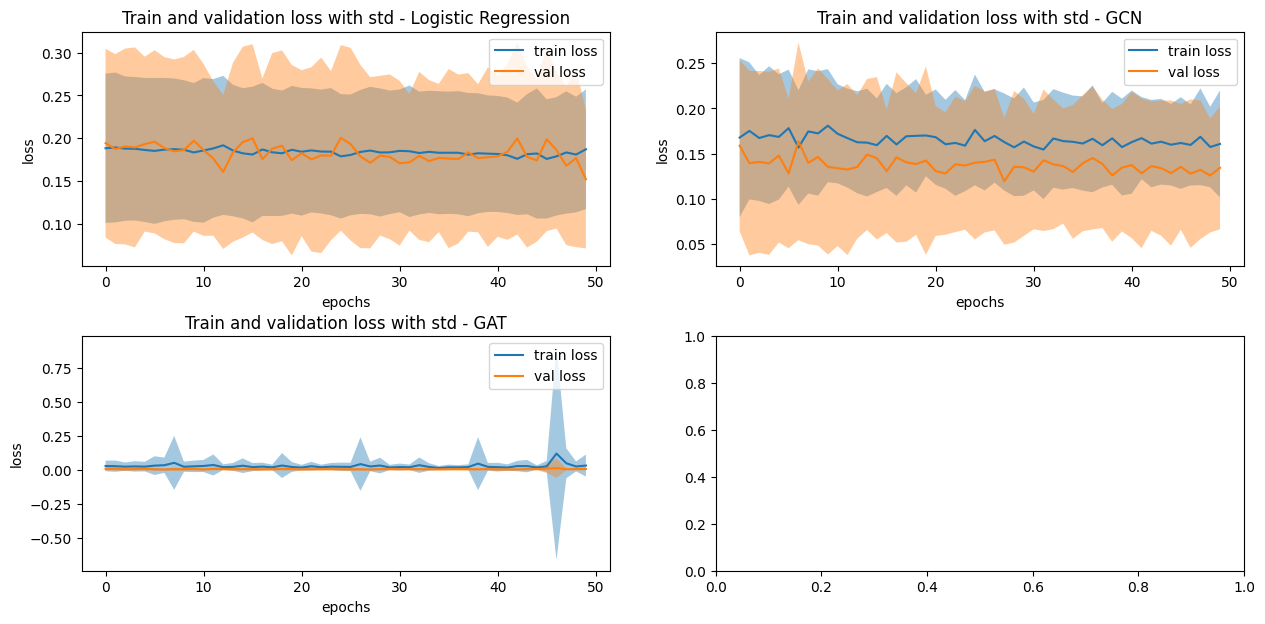

In [15]:
epochs = [k for k in range(n_epochs)]

fig, ax = plt.subplots(2,2,figsize=(15,7))

# Logistic Regression :
ax[0,0].plot(epochs, train_loss_log_reg,label='train loss')
ax[0,0].fill_between(epochs, train_loss_log_reg-std_train_loss_log_reg, train_loss_log_reg+std_train_loss_log_reg, alpha=0.4)
ax[0,0].plot(epochs, val_loss_log_reg,label='val loss')
ax[0,0].fill_between(epochs, val_loss_log_reg-std_val_loss_log_reg, val_loss_log_reg+std_val_loss_log_reg,alpha=0.4)
ax[0,0].set_xlabel('epochs')
ax[0,0].set_ylabel('loss')
ax[0,0].set_title('Train and validation loss with std - Logistic Regression')
ax[0,0].legend()

# GCN :
ax[0,1].plot(epochs, train_loss_gcn,label='train loss')
ax[0,1].fill_between(epochs, train_loss_gcn-std_train_loss_gcn, train_loss_gcn+std_train_loss_gcn, alpha=0.4)
ax[0,1].plot(epochs, val_loss_gcn,label='val loss')
ax[0,1].fill_between(epochs, val_loss_gcn-std_val_loss_gcn, val_loss_gcn+std_val_loss_gcn,alpha=0.4)
ax[0,1].set_xlabel('epochs')
ax[0,1].set_ylabel('loss')
ax[0,1].set_title('Train and validation loss with std - GCN')
ax[0,1].legend()

# GAT :
ax[1,0].plot(epochs, train_loss_gat,label='train loss')
ax[1,0].fill_between(epochs, train_loss_gat-std_train_loss_gat, train_loss_gat+std_train_loss_gat, alpha=0.4)
ax[1,0].plot(epochs, val_loss_gat,label='val loss')
ax[1,0].fill_between(epochs, val_loss_gat-std_val_loss_gat, val_loss_gat+std_val_loss_gat,alpha=0.4)
ax[1,0].set_xlabel('epochs')
ax[1,0].set_ylabel('loss')
ax[1,0].set_title('Train and validation loss with std - GAT')
ax[1,0].legend()

plt.subplots_adjust(hspace=0.3)